In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
features = "polar"
lag = "0"
model_save_dir = os.getcwd() + f"/ml-models/{features}-lag{lag}/"

In [4]:
def loadNpy(filename):
    with open(os.getcwd() + "/train-val-test/"+ filename, "rb") as f: return np.load(f)

db = f"db14/window-size-10/lag{lag}/{features}-features/"
data_type = ""

In [5]:
DIR = os.getcwd() + "/train-val-test/" + db

In [6]:
X_train, X_val, X_test = loadNpy(db + f"X_train.npy"), loadNpy(db + f"X_val.npy"), loadNpy(db + f"X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"y{data_type}_train.npy"), loadNpy(db + f"y{data_type}_val.npy"), loadNpy(db + f"y{data_type}_test.npy")

In [7]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [8]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train,1), npy_to_tensor(y_val,1), npy_to_tensor(y_test,1)

In [9]:
batch_size = 128

In [10]:
train_dataset = TensorDataset(X_train, y_train)

val_dataset = TensorDataset(X_val, y_val)

test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_iterator = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [11]:
torch.save(train_dataset, DIR + "train-dataset")
torch.save(val_dataset, DIR + "val-dataset")
torch.save(test_dataset, DIR + "test-dataset")

In [12]:
X_train.shape

torch.Size([17505, 1, 28, 28])

In [13]:
X_val.shape

torch.Size([5835, 1, 28, 28])

In [14]:
input_size = val_iterator

In [15]:
X_train.dtype

torch.float32

In [16]:
def eval_rnn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted)
            actual.append(labels)

        print(f'Accuracy of the model on the {total} samples: {100 * correct / total} %')
    return preds, actual, correct/total

In [46]:
from torchmetrics import ROC

def eval_cnn(data):
    # Test the model
    #fps = []
    preds = []
    actuals = []
    
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loaders[data]:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_ys = pred_ys + test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            preds.append(pred_y)
            actuals.append(labels)
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        return preds, actuals, correct/total
    pass

# CNN

In [47]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),     
            nn.ReLU()               
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 7 * 7, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [49]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=3136, out_features=2, bias=True)
)


In [50]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [51]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [53]:
from torch.autograd import Variable

num_epochs = 1000
cnn_epochs = {}

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                cnn_epochs[epoch] = {"loss": loss.item(), "train": eval_cnn(train_iterator), 
                             "val": eval_cnn(val_iterator), "test": eval_cnn(test_iterator)}
                cnn.train()
                pass
        pass
    pass

train(num_epochs, cnn, loaders)

Epoch [1/1000], Step [100/137], Loss: 0.3616


KeyError: <torch.utils.data.dataloader.DataLoader object at 0x7ff5ce4de970>

In [75]:
eval_cnn("val")
eval_cnn("test")

val Accuracy of the model on the 5835 val images: 0.896
test Accuracy of the model on the 5835 test images: 0.898


In [ ]:
roc = ROC(num_classes=2)
fpr, tpr, thresholds = roc(torch.FloatTensor(pred_ys), torch.FloatTensor(labs))

In [56]:
from torchviz import make_dot

dum_input = torch.ones(1,1,28,28)
a, b = cnn(dum_input)
make_dot(a, params=dict(cnn.named_parameters())).render(f"{model_save_dir}viz/cnn-{num_epochs}epochs-crossEnt-adamOpt",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/polar-lag0/viz/cnn-50epochs-crossEnt-adamOpt.png'

## CORE ML

## ONNX

In [67]:
import onnx

In [68]:
cnn.eval()
dummy_input = torch.randn(1, 1, 28, 28)
input_names = [ "actual_input" ]
output_names = [ "output" ]
model = cnn

In [69]:
torch.onnx.export(model, 
                  dummy_input,
                  "polar-window10-lag0-cnn.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

# LSTM

In [17]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 128
num_epochs = 1000
learning_rate = 0.01

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [19]:
epochs = {}

In [20]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_iterator)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_iterator):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            epochs[epoch] = {"loss": loss.item(), "train": eval_rnn(model, train_iterator), 
                             "val": eval_rnn(model, val_iterator), "test": eval_rnn(model, test_iterator)}
            
            model.train()

Epoch [1/1000], Step [100/137], Loss: 0.4079
Accuracy of the model on the 17505 samples: 86.12967723507569 %
Accuracy of the model on the 5835 samples: 85.48414738646102 %
Accuracy of the model on the 5835 samples: 86.0325621251071 %
Epoch [2/1000], Step [100/137], Loss: 0.3715
Accuracy of the model on the 17505 samples: 86.12967723507569 %
Accuracy of the model on the 5835 samples: 85.48414738646102 %
Accuracy of the model on the 5835 samples: 86.0325621251071 %
Epoch [3/1000], Step [100/137], Loss: 0.3532
Accuracy of the model on the 17505 samples: 86.2839188803199 %
Accuracy of the model on the 5835 samples: 86.08397600685518 %
Accuracy of the model on the 5835 samples: 86.13538988860326 %
Epoch [4/1000], Step [100/137], Loss: 0.3361
Accuracy of the model on the 17505 samples: 86.34104541559554 %
Accuracy of the model on the 5835 samples: 85.98114824335904 %
Accuracy of the model on the 5835 samples: 86.54670094258783 %
Epoch [5/1000], Step [100/137], Loss: 0.3614
Accuracy of the mo

Epoch [36/1000], Step [100/137], Loss: 0.3103
Accuracy of the model on the 17505 samples: 88.4318766066838 %
Accuracy of the model on the 5835 samples: 87.81491002570694 %
Accuracy of the model on the 5835 samples: 87.86632390745501 %
Epoch [37/1000], Step [100/137], Loss: 0.2976
Accuracy of the model on the 17505 samples: 88.403313339046 %
Accuracy of the model on the 5835 samples: 87.64353041988004 %
Accuracy of the model on the 5835 samples: 87.93487574978577 %
Epoch [38/1000], Step [100/137], Loss: 0.3049
Accuracy of the model on the 17505 samples: 88.12910596972294 %
Accuracy of the model on the 5835 samples: 87.74635818337617 %
Accuracy of the model on the 5835 samples: 88.02056555269922 %
Epoch [39/1000], Step [100/137], Loss: 0.3000
Accuracy of the model on the 17505 samples: 88.41473864610111 %
Accuracy of the model on the 5835 samples: 87.69494430162811 %
Accuracy of the model on the 5835 samples: 88.02056555269922 %
Epoch [40/1000], Step [100/137], Loss: 0.2987
Accuracy of t

Epoch [71/1000], Step [100/137], Loss: 0.2647
Accuracy of the model on the 17505 samples: 88.9345901171094 %
Accuracy of the model on the 5835 samples: 88.15766923736075 %
Accuracy of the model on the 5835 samples: 88.68894601542416 %
Epoch [72/1000], Step [100/137], Loss: 0.2772
Accuracy of the model on the 17505 samples: 89.15738360468437 %
Accuracy of the model on the 5835 samples: 88.22622107969151 %
Accuracy of the model on the 5835 samples: 88.72322193658954 %
Epoch [73/1000], Step [100/137], Loss: 0.2733
Accuracy of the model on the 17505 samples: 88.51756640959726 %
Accuracy of the model on the 5835 samples: 87.64353041988004 %
Accuracy of the model on the 5835 samples: 88.20908311910883 %
Epoch [74/1000], Step [100/137], Loss: 0.3085
Accuracy of the model on the 17505 samples: 87.99200228506142 %
Accuracy of the model on the 5835 samples: 87.40359897172236 %
Accuracy of the model on the 5835 samples: 87.48928877463582 %
Epoch [75/1000], Step [100/137], Loss: 0.3007
Accuracy of

Epoch [106/1000], Step [100/137], Loss: 0.2664
Accuracy of the model on the 17505 samples: 89.53441873750357 %
Accuracy of the model on the 5835 samples: 88.67180805484148 %
Accuracy of the model on the 5835 samples: 88.94601542416453 %
Epoch [107/1000], Step [100/137], Loss: 0.2583
Accuracy of the model on the 17505 samples: 89.47157954870038 %
Accuracy of the model on the 5835 samples: 88.53470437017995 %
Accuracy of the model on the 5835 samples: 88.94601542416453 %
Epoch [108/1000], Step [100/137], Loss: 0.2476
Accuracy of the model on the 17505 samples: 89.88289060268495 %
Accuracy of the model on the 5835 samples: 88.82604970008569 %
Accuracy of the model on the 5835 samples: 89.25449871465295 %
Epoch [109/1000], Step [100/137], Loss: 0.2737
Accuracy of the model on the 17505 samples: 89.8600399885747 %
Accuracy of the model on the 5835 samples: 88.67180805484148 %
Accuracy of the model on the 5835 samples: 88.96315338474722 %
Epoch [110/1000], Step [100/137], Loss: 0.2635
Accura

Epoch [141/1000], Step [100/137], Loss: 0.2628
Accuracy of the model on the 17505 samples: 88.86032562125106 %
Accuracy of the model on the 5835 samples: 88.0719794344473 %
Accuracy of the model on the 5835 samples: 88.31191088260498 %
Epoch [142/1000], Step [100/137], Loss: 0.2440
Accuracy of the model on the 17505 samples: 89.03170522707798 %
Accuracy of the model on the 5835 samples: 88.24335904027421 %
Accuracy of the model on the 5835 samples: 88.70608397600685 %
Epoch [143/1000], Step [100/137], Loss: 0.2482
Accuracy of the model on the 17505 samples: 88.99742930591259 %
Accuracy of the model on the 5835 samples: 88.02056555269922 %
Accuracy of the model on the 5835 samples: 88.41473864610111 %
Epoch [144/1000], Step [100/137], Loss: 0.2517
Accuracy of the model on the 17505 samples: 89.38017709225936 %
Accuracy of the model on the 5835 samples: 88.6203941730934 %
Accuracy of the model on the 5835 samples: 89.03170522707798 %
Epoch [145/1000], Step [100/137], Loss: 0.2508
Accurac

Epoch [176/1000], Step [100/137], Loss: 0.2354
Accuracy of the model on the 17505 samples: 90.56269637246501 %
Accuracy of the model on the 5835 samples: 89.61439588688945 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Epoch [177/1000], Step [100/137], Loss: 0.2301
Accuracy of the model on the 17505 samples: 90.73407597829191 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Accuracy of the model on the 5835 samples: 89.58011996572408 %
Epoch [178/1000], Step [100/137], Loss: 0.2301
Accuracy of the model on the 17505 samples: 90.75121393887461 %
Accuracy of the model on the 5835 samples: 89.3573264781491 %
Accuracy of the model on the 5835 samples: 89.5629820051414 %
Epoch [179/1000], Step [100/137], Loss: 0.3458
Accuracy of the model on the 17505 samples: 88.0719794344473 %
Accuracy of the model on the 5835 samples: 87.69494430162811 %
Accuracy of the model on the 5835 samples: 87.3350471293916 %
Epoch [180/1000], Step [100/137], Loss: 0.2854
Accuracy 

Epoch [211/1000], Step [100/137], Loss: 0.2372
Accuracy of the model on the 17505 samples: 91.39674378748929 %
Accuracy of the model on the 5835 samples: 89.82005141388174 %
Accuracy of the model on the 5835 samples: 89.27163667523564 %
Epoch [212/1000], Step [100/137], Loss: 0.2005
Accuracy of the model on the 17505 samples: 91.12253641816623 %
Accuracy of the model on the 5835 samples: 89.82005141388174 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Epoch [213/1000], Step [100/137], Loss: 0.2057
Accuracy of the model on the 17505 samples: 91.33961725221366 %
Accuracy of the model on the 5835 samples: 89.97429305912597 %
Accuracy of the model on the 5835 samples: 89.87146529562982 %
Epoch [214/1000], Step [100/137], Loss: 0.2099
Accuracy of the model on the 17505 samples: 91.1282490716938 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Epoch [215/1000], Step [100/137], Loss: 0.2067
Accurac

Epoch [246/1000], Step [100/137], Loss: 0.1953
Accuracy of the model on the 17505 samples: 91.47100828334762 %
Accuracy of the model on the 5835 samples: 90.1113967437875 %
Accuracy of the model on the 5835 samples: 89.58011996572408 %
Epoch [247/1000], Step [100/137], Loss: 0.2457
Accuracy of the model on the 17505 samples: 90.41416738074835 %
Accuracy of the model on the 5835 samples: 89.30591259640103 %
Accuracy of the model on the 5835 samples: 89.49443016281063 %
Epoch [248/1000], Step [100/137], Loss: 0.2223
Accuracy of the model on the 17505 samples: 91.26535275635533 %
Accuracy of the model on the 5835 samples: 89.76863753213368 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [249/1000], Step [100/137], Loss: 0.2320
Accuracy of the model on the 17505 samples: 90.80262782062267 %
Accuracy of the model on the 5835 samples: 89.61439588688945 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [250/1000], Step [100/137], Loss: 0.2107
Accura

Epoch [281/1000], Step [100/137], Loss: 0.3002
Accuracy of the model on the 17505 samples: 89.39731505284205 %
Accuracy of the model on the 5835 samples: 88.51756640959726 %
Accuracy of the model on the 5835 samples: 88.51756640959726 %
Epoch [282/1000], Step [100/137], Loss: 0.2307
Accuracy of the model on the 17505 samples: 91.36246786632391 %
Accuracy of the model on the 5835 samples: 89.7172236503856 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Epoch [283/1000], Step [100/137], Loss: 0.2100
Accuracy of the model on the 17505 samples: 91.64238788917451 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Accuracy of the model on the 5835 samples: 89.82005141388174 %
Epoch [284/1000], Step [100/137], Loss: 0.2496
Accuracy of the model on the 17505 samples: 91.66523850328477 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Epoch [285/1000], Step [100/137], Loss: 0.2033
Accurac

Epoch [316/1000], Step [100/137], Loss: 0.2179
Accuracy of the model on the 17505 samples: 90.23707512139389 %
Accuracy of the model on the 5835 samples: 89.37446443873179 %
Accuracy of the model on the 5835 samples: 89.42587832047987 %
Epoch [317/1000], Step [100/137], Loss: 0.2243
Accuracy of the model on the 17505 samples: 90.11710939731505 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Epoch [318/1000], Step [100/137], Loss: 0.2617
Accuracy of the model on the 17505 samples: 89.8886032562125 %
Accuracy of the model on the 5835 samples: 88.56898029134533 %
Accuracy of the model on the 5835 samples: 88.74035989717224 %
Epoch [319/1000], Step [100/137], Loss: 0.2201
Accuracy of the model on the 17505 samples: 90.17994858611826 %
Accuracy of the model on the 5835 samples: 89.23736075407027 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Epoch [320/1000], Step [100/137], Loss: 0.2440
Accurac

Epoch [351/1000], Step [100/137], Loss: 0.2069
Accuracy of the model on the 17505 samples: 91.51099685804056 %
Accuracy of the model on the 5835 samples: 90.45415595544131 %
Accuracy of the model on the 5835 samples: 90.02570694087403 %
Epoch [352/1000], Step [100/137], Loss: 0.1900
Accuracy of the model on the 17505 samples: 91.13396172522137 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Accuracy of the model on the 5835 samples: 89.80291345329906 %
Epoch [353/1000], Step [100/137], Loss: 0.1984
Accuracy of the model on the 17505 samples: 90.88831762353614 %
Accuracy of the model on the 5835 samples: 90.02570694087403 %
Accuracy of the model on the 5835 samples: 89.76863753213368 %
Epoch [354/1000], Step [100/137], Loss: 0.2088
Accuracy of the model on the 17505 samples: 91.21965152813482 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Epoch [355/1000], Step [100/137], Loss: 0.1957
Accura

Epoch [386/1000], Step [100/137], Loss: 0.1989
Accuracy of the model on the 17505 samples: 91.51670951156812 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Epoch [387/1000], Step [100/137], Loss: 0.2028
Accuracy of the model on the 17505 samples: 91.88803199085976 %
Accuracy of the model on the 5835 samples: 90.4370179948586 %
Accuracy of the model on the 5835 samples: 90.04284490145673 %
Epoch [388/1000], Step [100/137], Loss: 0.1923
Accuracy of the model on the 17505 samples: 91.32247929163097 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Epoch [389/1000], Step [100/137], Loss: 0.2261
Accuracy of the model on the 17505 samples: 91.45387032276493 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Accuracy of the model on the 5835 samples: 90.04284490145673 %
Epoch [390/1000], Step [100/137], Loss: 0.1875
Accura

Epoch [421/1000], Step [100/137], Loss: 0.1911
Accuracy of the model on the 17505 samples: 91.99657240788346 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Epoch [422/1000], Step [100/137], Loss: 0.2020
Accuracy of the model on the 17505 samples: 91.47100828334762 %
Accuracy of the model on the 5835 samples: 89.40874035989717 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Epoch [423/1000], Step [100/137], Loss: 0.2026
Accuracy of the model on the 17505 samples: 91.92230791202513 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Epoch [424/1000], Step [100/137], Loss: 0.2204
Accuracy of the model on the 17505 samples: 91.596686660954 %
Accuracy of the model on the 5835 samples: 90.00856898029134 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Epoch [425/1000], Step [100/137], Loss: 0.2207
Accuracy 

Epoch [456/1000], Step [100/137], Loss: 0.1730
Accuracy of the model on the 17505 samples: 92.32219365895459 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Epoch [457/1000], Step [100/137], Loss: 0.1663
Accuracy of the model on the 17505 samples: 92.71636675235646 %
Accuracy of the model on the 5835 samples: 90.24850042844902 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Epoch [458/1000], Step [100/137], Loss: 0.1781
Accuracy of the model on the 17505 samples: 92.51071122536418 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Accuracy of the model on the 5835 samples: 90.29991431019708 %
Epoch [459/1000], Step [100/137], Loss: 0.1649
Accuracy of the model on the 17505 samples: 92.35646958011996 %
Accuracy of the model on the 5835 samples: 90.40274207369323 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Epoch [460/1000], Step [100/137], Loss: 0.2044
Accur

Epoch [491/1000], Step [100/137], Loss: 0.1572
Accuracy of the model on the 17505 samples: 92.67637817766352 %
Accuracy of the model on the 5835 samples: 89.73436161096829 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Epoch [492/1000], Step [100/137], Loss: 0.1782
Accuracy of the model on the 17505 samples: 92.37360754070265 %
Accuracy of the model on the 5835 samples: 89.54584404455869 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Epoch [493/1000], Step [100/137], Loss: 0.1749
Accuracy of the model on the 17505 samples: 92.31076835189945 %
Accuracy of the model on the 5835 samples: 89.46015424164524 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Epoch [494/1000], Step [100/137], Loss: 0.1670
Accuracy of the model on the 17505 samples: 92.67637817766352 %
Accuracy of the model on the 5835 samples: 89.5629820051414 %
Accuracy of the model on the 5835 samples: 90.40274207369323 %
Epoch [495/1000], Step [100/137], Loss: 0.1599
Accurac

Epoch [526/1000], Step [100/137], Loss: 0.1779
Accuracy of the model on the 17505 samples: 92.17366466723793 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Accuracy of the model on the 5835 samples: 89.63153384747216 %
Epoch [527/1000], Step [100/137], Loss: 0.1539
Accuracy of the model on the 17505 samples: 92.71065409882891 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Epoch [528/1000], Step [100/137], Loss: 0.1552
Accuracy of the model on the 17505 samples: 93.3390459868609 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Accuracy of the model on the 5835 samples: 90.67694944301628 %
Epoch [529/1000], Step [100/137], Loss: 0.1535
Accuracy of the model on the 17505 samples: 92.52784918594688 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Accuracy of the model on the 5835 samples: 90.33419023136247 %
Epoch [530/1000], Step [100/137], Loss: 0.1704
Accurac

Epoch [561/1000], Step [100/137], Loss: 0.2241
Accuracy of the model on the 17505 samples: 90.1399600114253 %
Accuracy of the model on the 5835 samples: 89.25449871465295 %
Accuracy of the model on the 5835 samples: 89.08311910882605 %
Epoch [562/1000], Step [100/137], Loss: 0.2223
Accuracy of the model on the 17505 samples: 90.00856898029134 %
Accuracy of the model on the 5835 samples: 88.77463581833761 %
Accuracy of the model on the 5835 samples: 88.86032562125106 %
Epoch [563/1000], Step [100/137], Loss: 0.2365
Accuracy of the model on the 17505 samples: 90.24278777492145 %
Accuracy of the model on the 5835 samples: 89.46015424164524 %
Accuracy of the model on the 5835 samples: 89.15167095115682 %
Epoch [564/1000], Step [100/137], Loss: 0.2130
Accuracy of the model on the 17505 samples: 90.04284490145673 %
Accuracy of the model on the 5835 samples: 89.23736075407027 %
Accuracy of the model on the 5835 samples: 89.18594687232219 %
Epoch [565/1000], Step [100/137], Loss: 0.2380
Accura

Epoch [596/1000], Step [100/137], Loss: 0.2426
Accuracy of the model on the 17505 samples: 90.17994858611826 %
Accuracy of the model on the 5835 samples: 89.27163667523564 %
Accuracy of the model on the 5835 samples: 89.22022279348758 %
Epoch [597/1000], Step [100/137], Loss: 0.2494
Accuracy of the model on the 17505 samples: 90.62553556126821 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Epoch [598/1000], Step [100/137], Loss: 0.2638
Accuracy of the model on the 17505 samples: 90.13424735789775 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Accuracy of the model on the 5835 samples: 89.11739502999143 %
Epoch [599/1000], Step [100/137], Loss: 0.2495
Accuracy of the model on the 17505 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 89.30591259640103 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [600/1000], Step [100/137], Loss: 0.2558
Accur

Epoch [631/1000], Step [100/137], Loss: 0.2286
Accuracy of the model on the 17505 samples: 90.62553556126821 %
Accuracy of the model on the 5835 samples: 89.7172236503856 %
Accuracy of the model on the 5835 samples: 89.59725792630677 %
Epoch [632/1000], Step [100/137], Loss: 0.2353
Accuracy of the model on the 17505 samples: 90.35704084547272 %
Accuracy of the model on the 5835 samples: 89.76863753213368 %
Accuracy of the model on the 5835 samples: 89.44301628106255 %
Epoch [633/1000], Step [100/137], Loss: 0.2312
Accuracy of the model on the 17505 samples: 90.88831762353614 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Epoch [634/1000], Step [100/137], Loss: 0.2617
Accuracy of the model on the 17505 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 88.9802913453299 %
Accuracy of the model on the 5835 samples: 89.25449871465295 %
Epoch [635/1000], Step [100/137], Loss: 0.2206
Accuracy

Epoch [666/1000], Step [100/137], Loss: 0.2400
Accuracy of the model on the 17505 samples: 91.08826049700086 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 89.76863753213368 %
Epoch [667/1000], Step [100/137], Loss: 0.2115
Accuracy of the model on the 17505 samples: 91.35675521279634 %
Accuracy of the model on the 5835 samples: 90.05998286203942 %
Accuracy of the model on the 5835 samples: 90.29991431019708 %
Epoch [668/1000], Step [100/137], Loss: 0.2530
Accuracy of the model on the 17505 samples: 89.4830048557555 %
Accuracy of the model on the 5835 samples: 88.15766923736075 %
Accuracy of the model on the 5835 samples: 88.84318766066838 %
Epoch [669/1000], Step [100/137], Loss: 0.2420
Accuracy of the model on the 17505 samples: 90.2827763496144 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Accuracy of the model on the 5835 samples: 89.22022279348758 %
Epoch [670/1000], Step [100/137], Loss: 0.2492
Accurac

Epoch [701/1000], Step [100/137], Loss: 0.2080
Accuracy of the model on the 17505 samples: 91.61953727506426 %
Accuracy of the model on the 5835 samples: 90.45415595544131 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Epoch [702/1000], Step [100/137], Loss: 0.1903
Accuracy of the model on the 17505 samples: 91.82519280205655 %
Accuracy of the model on the 5835 samples: 90.4370179948586 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Epoch [703/1000], Step [100/137], Loss: 0.1980
Accuracy of the model on the 17505 samples: 91.60239931448157 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Epoch [704/1000], Step [100/137], Loss: 0.1916
Accuracy of the model on the 17505 samples: 91.52813481862324 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Epoch [705/1000], Step [100/137], Loss: 0.1949
Accurac

Epoch [736/1000], Step [100/137], Loss: 0.1829
Accuracy of the model on the 17505 samples: 92.04227363610397 %
Accuracy of the model on the 5835 samples: 90.02570694087403 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Epoch [737/1000], Step [100/137], Loss: 0.2154
Accuracy of the model on the 17505 samples: 91.37389317337903 %
Accuracy of the model on the 5835 samples: 89.80291345329906 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Epoch [738/1000], Step [100/137], Loss: 0.1915
Accuracy of the model on the 17505 samples: 92.04798628963154 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Accuracy of the model on the 5835 samples: 90.00856898029134 %
Epoch [739/1000], Step [100/137], Loss: 0.2267
Accuracy of the model on the 17505 samples: 91.04255926878035 %
Accuracy of the model on the 5835 samples: 90.19708654670094 %
Accuracy of the model on the 5835 samples: 89.61439588688945 %
Epoch [740/1000], Step [100/137], Loss: 0.1937
Accur

Epoch [771/1000], Step [100/137], Loss: 0.1774
Accuracy of the model on the 17505 samples: 92.4135961153956 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Accuracy of the model on the 5835 samples: 90.24850042844902 %
Epoch [772/1000], Step [100/137], Loss: 0.1801
Accuracy of the model on the 17505 samples: 92.40788346186804 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Accuracy of the model on the 5835 samples: 90.36846615252784 %
Epoch [773/1000], Step [100/137], Loss: 0.1819
Accuracy of the model on the 17505 samples: 92.539274493002 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Accuracy of the model on the 5835 samples: 90.29991431019708 %
Epoch [774/1000], Step [100/137], Loss: 0.1693
Accuracy of the model on the 17505 samples: 92.38503284775778 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Accuracy of the model on the 5835 samples: 90.45415595544131 %
Epoch [775/1000], Step [100/137], Loss: 0.1764
Accuracy 

Epoch [806/1000], Step [100/137], Loss: 0.1941
Accuracy of the model on the 17505 samples: 91.84233076263925 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Accuracy of the model on the 5835 samples: 90.02570694087403 %
Epoch [807/1000], Step [100/137], Loss: 0.2248
Accuracy of the model on the 17505 samples: 91.31105398457584 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Accuracy of the model on the 5835 samples: 89.54584404455869 %
Epoch [808/1000], Step [100/137], Loss: 0.1888
Accuracy of the model on the 17505 samples: 92.5849757212225 %
Accuracy of the model on the 5835 samples: 90.40274207369323 %
Accuracy of the model on the 5835 samples: 90.24850042844902 %
Epoch [809/1000], Step [100/137], Loss: 0.1872
Accuracy of the model on the 17505 samples: 92.84775778349044 %
Accuracy of the model on the 5835 samples: 90.48843187660668 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Epoch [810/1000], Step [100/137], Loss: 0.1991
Accurac

Epoch [841/1000], Step [100/137], Loss: 0.1767
Accuracy of the model on the 17505 samples: 92.87632105112824 %
Accuracy of the model on the 5835 samples: 89.97429305912597 %
Accuracy of the model on the 5835 samples: 90.59125964010283 %
Epoch [842/1000], Step [100/137], Loss: 0.1779
Accuracy of the model on the 17505 samples: 92.91059697229363 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Accuracy of the model on the 5835 samples: 90.471293916024 %
Epoch [843/1000], Step [100/137], Loss: 0.1824
Accuracy of the model on the 17505 samples: 93.28191945158527 %
Accuracy of the model on the 5835 samples: 90.2827763496144 %
Accuracy of the model on the 5835 samples: 90.4370179948586 %
Epoch [844/1000], Step [100/137], Loss: 0.1726
Accuracy of the model on the 17505 samples: 92.55641245358468 %
Accuracy of the model on the 5835 samples: 89.97429305912597 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Epoch [845/1000], Step [100/137], Loss: 0.2141
Accuracy 

Epoch [876/1000], Step [100/137], Loss: 0.1875
Accuracy of the model on the 17505 samples: 92.63067694944301 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Epoch [877/1000], Step [100/137], Loss: 0.1645
Accuracy of the model on the 17505 samples: 93.22479291630962 %
Accuracy of the model on the 5835 samples: 90.0771208226221 %
Accuracy of the model on the 5835 samples: 90.2827763496144 %
Epoch [878/1000], Step [100/137], Loss: 0.2344
Accuracy of the model on the 17505 samples: 91.91088260497001 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Accuracy of the model on the 5835 samples: 89.7172236503856 %
Epoch [879/1000], Step [100/137], Loss: 0.1635
Accuracy of the model on the 17505 samples: 92.55069980005713 %
Accuracy of the model on the 5835 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Epoch [880/1000], Step [100/137], Loss: 0.2120
Accuracy

Epoch [911/1000], Step [100/137], Loss: 0.1726
Accuracy of the model on the 17505 samples: 92.82490716938018 %
Accuracy of the model on the 5835 samples: 90.2827763496144 %
Accuracy of the model on the 5835 samples: 90.2827763496144 %
Epoch [912/1000], Step [100/137], Loss: 0.1663
Accuracy of the model on the 17505 samples: 92.96772350756926 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Accuracy of the model on the 5835 samples: 90.24850042844902 %
Epoch [913/1000], Step [100/137], Loss: 0.1675
Accuracy of the model on the 17505 samples: 92.71065409882891 %
Accuracy of the model on the 5835 samples: 90.2827763496144 %
Accuracy of the model on the 5835 samples: 90.29991431019708 %
Epoch [914/1000], Step [100/137], Loss: 0.1787
Accuracy of the model on the 17505 samples: 92.99628677520708 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Epoch [915/1000], Step [100/137], Loss: 0.1820
Accuracy

Epoch [946/1000], Step [100/137], Loss: 0.1965
Accuracy of the model on the 17505 samples: 92.70494144530134 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Epoch [947/1000], Step [100/137], Loss: 0.1981
Accuracy of the model on the 17505 samples: 92.44787203656098 %
Accuracy of the model on the 5835 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Epoch [948/1000], Step [100/137], Loss: 0.1835
Accuracy of the model on the 17505 samples: 92.96772350756926 %
Accuracy of the model on the 5835 samples: 90.05998286203942 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Epoch [949/1000], Step [100/137], Loss: 0.1860
Accuracy of the model on the 17505 samples: 92.72207940588403 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Epoch [950/1000], Step [100/137], Loss: 0.2020
Accuracy

Epoch [981/1000], Step [100/137], Loss: 0.1732
Accuracy of the model on the 17505 samples: 92.32790631248214 %
Accuracy of the model on the 5835 samples: 89.64867180805484 %
Accuracy of the model on the 5835 samples: 89.9057412167952 %
Epoch [982/1000], Step [100/137], Loss: 0.2102
Accuracy of the model on the 17505 samples: 92.83061982290774 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Epoch [983/1000], Step [100/137], Loss: 0.1784
Accuracy of the model on the 17505 samples: 92.67637817766352 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Accuracy of the model on the 5835 samples: 90.0771208226221 %
Epoch [984/1000], Step [100/137], Loss: 0.2007
Accuracy of the model on the 17505 samples: 93.37903456155384 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Accuracy of the model on the 5835 samples: 90.38560411311055 %
Epoch [985/1000], Step [100/137], Loss: 0.1898
Accurac

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Val Accuracy of the model on the {len(y_val)} val images: {100 * correct / total} %') 
            
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the {len(y_test)} test images: {100 * correct / total} %') 

In [75]:
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [76]:
from torchviz import make_dot

dum_input = torch.ones(1,28,28).to(device)
a = model(dum_input)
make_dot(a, params=dict(model.named_parameters())).render(f"{save_dir}viz/lstm-{num_epochs}epochs-{num_layers}layers-{hidden_size}hidden",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/polar-lag0/viz/lstm-20epochs-2layers-128hidden.png'

In [25]:
train = []
val = []
test = []
loss = []

for i in range(num_epochs):
    ep = epochs[i]
    train.append(ep["train"][2])
    val.append(ep["val"][2])
    test.append(ep["test"][2])
    loss.append(ep["loss"])

Text(0.5, 0, 'Epoch #')

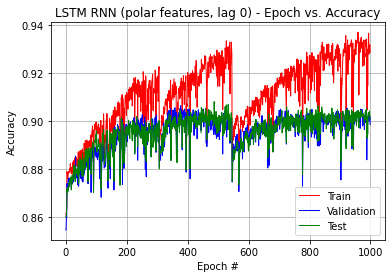

In [45]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train, c="r", lw=1, label="Train")
plt.plot(epochs, val, c="b", lw=1, label="Validation")
plt.plot(epochs, test, c="g", lw=1, label="Test")
plt.grid(True)
plt.legend(loc="lower right")
plt.title("LSTM RNN (polar features, lag 0) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")

In [41]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [69]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [114]:
vgg11_config = [6, 'M', 12, 'M', 24, 24, 'M']#[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [115]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [116]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [117]:
OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2

## TRAINING

In [118]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [119]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [120]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

RuntimeError: Given input size: (12x1x1). Calculated output size: (12x0x0). Output size is too small